In [11]:
# 가우스 잡음 추가 함수
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 가우스 노이즈
# noisy_pixel = original_pixel + N(u=0, e=scale)  u = 평균, e = 스케일
# 평균 = 0 : 픽셀을 전체적으로 밝히거나 어둡게 하지 않음
# 표준편차 = scale -> 값이 클수록 노이즈가 강해짐
# 0.8 -> 노이즈의 양 많고, 숫자 일부를 흐릿

In [12]:
def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x + np.random.normal(
        loc = 0, scale = scale, size = x.shape
    )
    gaussian_data_x = np.clip(gaussian_data_x, 0, 1) # 이미지픽셀의 값을 0과 1사이로 정규화
    gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)
    return gaussian_data_x


In [13]:
training_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

C:\Users\playdata2\AppData\Local\Temp\ipykernel_4620\1267212853.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
C:\Users\playdata2\AppData\Local\Temp\ipykernel_4620\1267212853.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x, dtype=torch.float32)


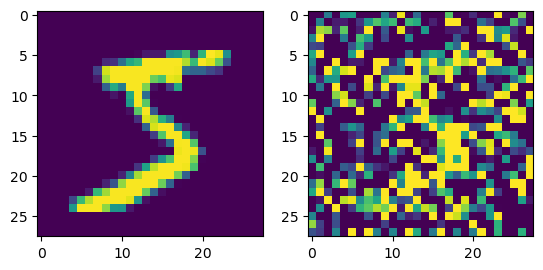

In [14]:
img, label = next(iter(training_data))
gaussian = gaussian_noise(img)
img = img.permute(1,2,0)
gaussian = gaussian.permute(1,2,0)

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(gaussian)

In [16]:
# 학습용 데이터셋
from torch.utils.data.dataset import Dataset
class Denoise(Dataset):
    def __init__(self):
        self.mnist = MNIST(root='./', train=True, download=True, transform=ToTensor())
        self.data = []
        # 잡음
        for data, label in self.mnist:
            noisy = gaussian_noise(data)
            self.data.append(noisy.unsqueeze(0)) # (1, 1, 28, 28)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data = self.data[index]
        label = self.mnist.data[index] / 255 # 원본이미지도 0 ~ 1 정규화
        return data, label

In [21]:
# 합성곱 기본 블럭
from torch import nn
# conv-relu-conv-relu
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel):
        super(BasicBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.model(x)

In [23]:
sample_data = torch.randn(1, 28, 28)
sample_model = BasicBlock(1, 20, 10)
sample_model(sample_data).size()

torch.Size([20, 28, 28])

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,20,8)
        self.pool = nn.AvgPool2d(2)
    def forward(self, x):
        x = self.pool(self.conv1(x)) # 1,16,14,14 
        out = self.pool(self.conv2(x)) # 1,8,7,7
        return out

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        # 출력층
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

        # 업샘플링 층
        self.upsampling1 = nn.ConvTranspose2d(8,8, kernel_size=2, stride=2)
        self.upsampling2 = nn.ConvTranspose2d(16,16, kernel_size=2, stride=2)
    def forward(self, x):
        self.upsampling1(self.conv1(x))
        self.upsampling2(self.conv2(x))
        out = self.conv3(x)
        return out

In [ ]:
# CAE 오토인코더
# 인코더와 디코더를 연결 : 인코더의 출력을 디코더의 입력으로 제공
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
    def forward(self, x):
        pass